# Caches and Data Locality

In [1]:
import timeit
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

Modern CPUs have a hierarchy of cache memories (L3, L2, L1) which try to hide latencies of reading/writing from/to main memory. The bandwith on our Intel E5-2690 v3 Processor between the different elements of the memory hierarchy is the following:

| Link            | Bandwidth | Latency |
|-----------------|-----------|---------|
| **L1 &harr; core** | Read 155 GB/s + Write 77.5 GB/s per core | >= 4 cycles |
| **L1 &harr; L2**   | 155 GB/s per core | >= 11 cycles |
| **L2 &harr; L3**   | 77.5 GB/s total | >= 36 cycles |
| **L3 &harr; RAM**  | 68.3 GB/s total | >= 100 cycles |

The latencies corresponds to the time it takes to load a random element from a specific element of the memory hierarchy. It is important to note that the connections L2 &harr; L3 and L3 &harr; RAM have to feed all 12 cores, and so are comparably slow as compared to the bandwidths L2 &harr; L1 and L1 &harr; core.

<div class="alert alert-block alert-info">
<b>Now it's your turn...</b><br>
<b>3.</b> Find out the clock frequency of the Intel Haswell CPUs of Piz Daint by inspecting the <tt>/proc/cpuinfo</tt> file (see below).<br>
<b>4.</b> Modern CPUs have multiple cores, which each contain a control unit and an ALU. Find out the number of cores on the CPUs of Piz Daint. Check your answer on the <a href="https://www.cscs.ch/computers/piz-daint/">CSCS website</a> looking at data for the Piz Daint XC50 compute nodes.<br>
</div>

In [2]:
for n in range(1, 16):
    num_elem = 2**n * 1024 // 4 - 256
    num_bytes = 2**n * 1024 // 4
    a = np.empty( num_elem, dtype=np.float32 )
    tic = timeit.default_timer()
    for iter in range(1000):
        b = a.copy()
    toc = timeit.default_timer()
    runtime = (toc - tic) / 1000
    print("{:10d} KB  {:10.3f} ns  {:10.3f} GB/s".format( \
        num_bytes // 1024, runtime*1e9 / num_bytes, num_bytes / 1024**3 / runtime ) )

         0 KB       1.719 ns       0.542 GB/s
         1 KB       0.678 ns       1.374 GB/s
         2 KB       0.377 ns       2.471 GB/s
         4 KB       0.324 ns       2.877 GB/s
         8 KB       0.235 ns       3.969 GB/s
        16 KB       0.194 ns       4.795 GB/s
        32 KB       0.182 ns       5.109 GB/s
        64 KB       0.180 ns       5.166 GB/s
       128 KB       0.172 ns       5.415 GB/s
       256 KB       0.156 ns       5.963 GB/s
       512 KB       0.156 ns       5.976 GB/s
      1024 KB       0.160 ns       5.829 GB/s
      2048 KB       0.159 ns       5.842 GB/s
      4096 KB       0.249 ns       3.738 GB/s
      8192 KB       1.709 ns       0.545 GB/s


In [3]:
%%bash
module load daint-gpu
module switch PrgEnv-gnu PrgEnv-cray

make clean
make VERSION=orig
make VERSION=counters
make VERSION=kblocking
make VERSION=inlining
make VERSION=inlining_v2

rm -f -rf *~ *.o *.mod *.MOD *.i *.x *.x+orig *.x+[0-9]* core.* *.out *.dat *.lst
ftn -O3 -hfp3 -eZ -ffree -N255 -ec -eC -eI -eF -rm -c m_utils.F90
ftn -O3 -hfp3 -eZ -ffree -N255 -ec -eC -eI -eF -rm -c stencil2d-orig.F90
ftn -O3 -hfp3 -eZ -ffree -N255 -ec -eC -eI -eF -rm m_utils.o stencil2d-orig.o -o stencil2d-orig.x
cp stencil2d-orig.x stencil2d.x
ftn -O3 -hfp3 -eZ -ffree -N255 -ec -eC -eI -eF -rm -c stencil2d-counters.F90
ftn -O3 -hfp3 -eZ -ffree -N255 -ec -eC -eI -eF -rm m_utils.o stencil2d-counters.o -o stencil2d-counters.x
cp stencil2d-counters.x stencil2d.x
ftn -O3 -hfp3 -eZ -ffree -N255 -ec -eC -eI -eF -rm -c stencil2d-kblocking.F90
ftn -O3 -hfp3 -eZ -ffree -N255 -ec -eC -eI -eF -rm m_utils.o stencil2d-kblocking.o -o stencil2d-kblocking.x
cp stencil2d-kblocking.x stencil2d.x
ftn -O3 -hfp3 -eZ -ffree -N255 -ec -eC -eI -eF -rm -c stencil2d-inlining.F90
ftn -O3 -hfp3 -eZ -ffree -N255 -ec -eC -eI -eF -rm m_utils.o stencil2d-inlining.o -o stencil2d-inlining.x
cp stencil2d-inlining.x 

In [ ]:
%%bash
for tag in orig kblocking inlining inlining_v2 ; do
    echo "=> running stencil2d-${tag}.x in scan mode (output in result_stencil2d-${tag}.py)"
    srun -n 12 ./stencil2d-${tag}.x --scan --nz 64 --num_iter 128 1> result_stencil2d-${tag}.py
done

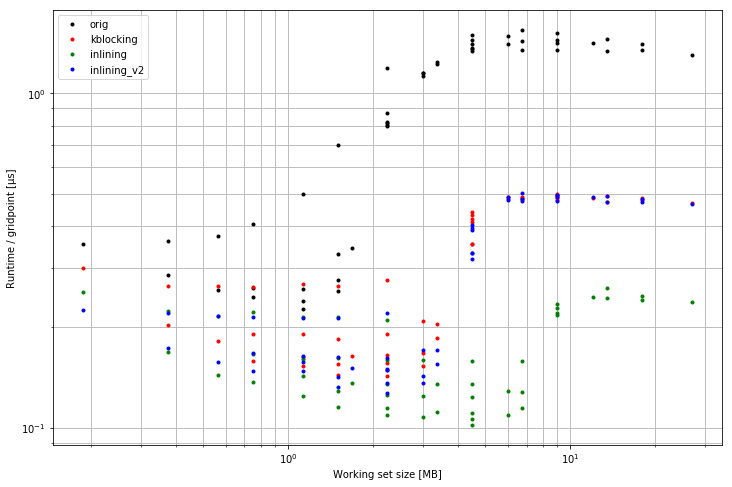

In [19]:
tags = [ "orig", "kblocking", "inlining", "inlining_v2" ]
colors = [ "black", "red", "green", "blue" ]
for tag, color in zip(tags, colors):
    exec(open("result_stencil2d-" + tag + ".py").read())
    vars()["data_" + tag] = data
    nxnynz = data[:, 1] * data[:, 2] * data[:, 3]
    runtime = data[:, 5]
    plt.loglog( 3 * nxnynz * 4 / 1024. / 1024., runtime / nxnynz * 1.0e6 , '.', color=color);
plt.xlabel( 'Working set size [MB]' );
plt.ylabel( 'Runtime / gridpoint [µs]' );
plt.grid(b=True, which='both')
plt.legend(tags)
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(12, 8)